#Installing Required Libraries

In [2]:
#!pip install kagglehub geopandas folium geopy openai transformers pandas matplotlib

#Importing Required Libraries

In [20]:
from sklearn.preprocessing import StandardScaler
import kagglehub
import pandas as pd
import geopandas as gpd
import folium
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

#Downloading Dataset from Kaggle

In [4]:
path = kagglehub.dataset_download("sujalsuthar/amazon-delivery-dataset")
print("Path to dataset files:", path)

100%|██████████| 1.53M/1.53M [00:01<00:00, 1.51MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/sujalsuthar/amazon-delivery-dataset/versions/1


# Loading the dataset

In [6]:
data_path = f"{path}/amazon_delivery.csv"  # Update with the specific file path in the dataset
df = pd.read_csv(data_path)

# Inspecting dataset

In [9]:
df.head()

,Order_ID,Agent_Age,Agent_Rating,Store_Latitude,Store_Longitude,Drop_Latitude,Drop_Longitude,Order_Date,Order_Time,Pickup_Time,Weather,Traffic,Vehicle,Area,Delivery_Time,Category
0,ialx566343618,37,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,11:30:00,11:45:00,Sunny,High,motorcycle,Urban,120,Clothing
1,akqg208421122,34,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,19:45:00,19:50:00,Stormy,Jam,scooter,Metropolitian,165,Electronics
2,njpu434582536,23,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,08:30:00,08:45:00,Sandstorms,Low,motorcycle,Urban,130,Sports
3,rjto796129700,38,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,18:00:00,18:10:00,Sunny,Medium,motorcycle,Metropolitian,105,Cosmetics
4,zguw716275638,32,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,13:30:00,13:45:00,Cloudy,High,scooter,Metropolitian,150,Toys


Inspecting data structure and types

In [12]:
print("Dataset Info:")
print(df.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43739 entries, 0 to 43738
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order_ID         43739 non-null  object 
 1   Agent_Age        43739 non-null  int64  
 2   Agent_Rating     43685 non-null  float64
 3   Store_Latitude   43739 non-null  float64
 4   Store_Longitude  43739 non-null  float64
 5   Drop_Latitude    43739 non-null  float64
 6   Drop_Longitude   43739 non-null  float64
 7   Order_Date       43739 non-null  object 
 8   Order_Time       43739 non-null  object 
 9   Pickup_Time      43739 non-null  object 
 10  Weather          43648 non-null  object 
 11  Traffic          43739 non-null  object 
 12  Vehicle          43739 non-null  object 
 13  Area             43739 non-null  object 
 14  Delivery_Time    43739 non-null  int64  
 15  Category         43739 non-null  object 
dtypes: float64(5), int64(2), object(9)
memory us

# Delivery times distribution

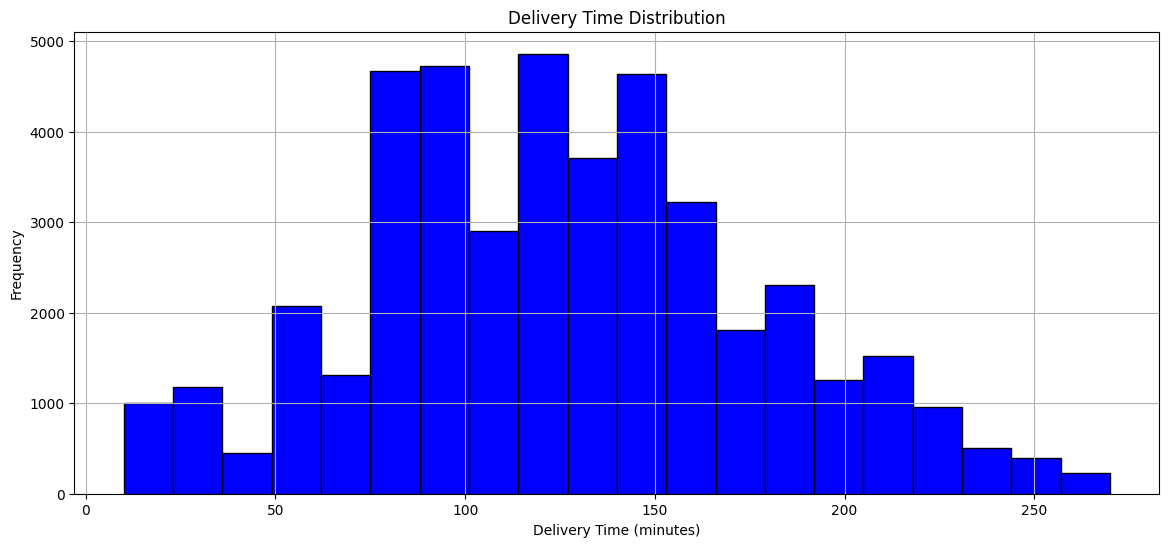

In [15]:
df['Delivery_Time'].hist(bins=20, color='blue', edgecolor='black', figsize=(14, 6))
plt.title("Delivery Time Distribution")
plt.xlabel("Delivery Time (minutes)")
plt.ylabel("Frequency")
plt.show()

# Visualizing drop locations on map

In [30]:
for _, row in df.head(100).iterrows():
    folium.Marker([row['Drop_Latitude'], row['Drop_Longitude']], popup=row['Order_ID']).add_to(m)
m

#Feature Engineering for Clustering

Selecting relevant columns for clustering (drop and store locations)

In [17]:
features = df[['Store_Latitude', 'Store_Longitude', 'Drop_Latitude', 'Drop_Longitude']]

# Standardizing the features

In [21]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

Performing clustering using K-Means

In [22]:
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(features_scaled)

Assigning clusters to the dataset

In [23]:
df['Cluster'] = kmeans.labels_

# Visualizing clusters

Cluster Visualization...


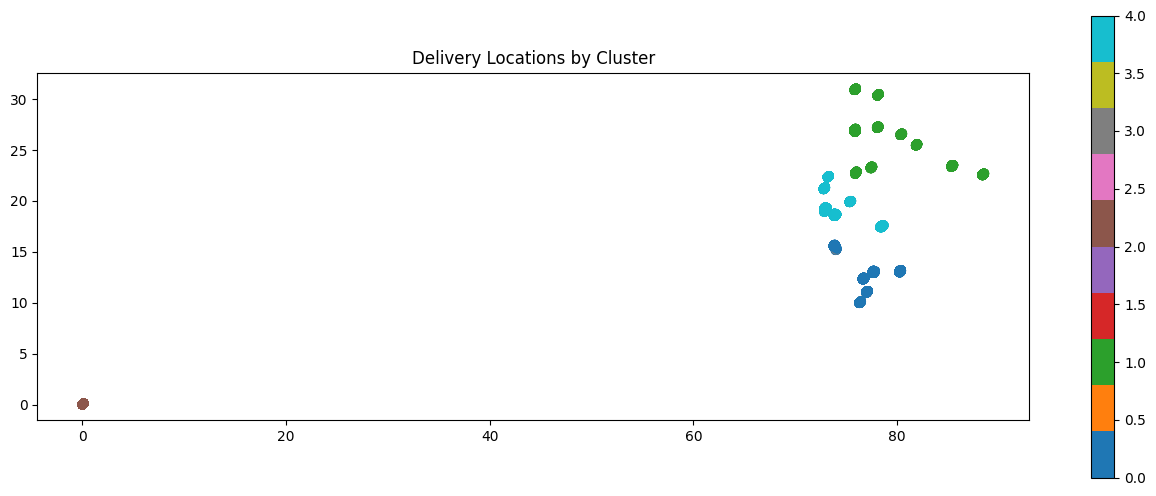

In [25]:
print("Cluster Visualization...")
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Drop_Longitude, df.Drop_Latitude))
gdf.plot(column='Cluster', cmap='tab10', legend=True, figsize=(16, 6))
plt.title("Delivery Locations by Cluster")
plt.show()

#Route Optimization

In [26]:
from geopy.distance import geodesic

def calculate_route_distance(route_points):
    """
    Calculate the total distance of a route using geodesic distances.
    :param route_points: List of tuples (latitude, longitude)
    :return: Total distance in kilometers
    """
    total_distance = 0.0
    for i in range(len(route_points) - 1):
        total_distance += geodesic(route_points[i], route_points[i + 1]).km
    return total_distance

# Example route calculation

In [27]:
route_points = [(df.iloc[i]['Drop_Latitude'], df.iloc[i]['Drop_Longitude']) for i in range(10)]
route_distance = calculate_route_distance(route_points)
print(f"Total Route Distance for First 10 Deliveries: {route_distance:.2f} km")

Total Route Distance for First 10 Deliveries: 6811.32 km


#Saving Processed Data

In [ ]:
output_file = "processed_delivery_data.csv"
df.to_csv(output_file, index=False)
print(f"Processed data saved to {output_file}")